# Forecasting Day-Ahead Price and CO2 Intensity

Predicting energy prices and CO2 intensities is crucial for energy-efficient and energy-flexible production. The following notebook is able to load the already computed forecast models and make a forecast for the next days.

In [1]:
# Import libraries

# Self-written utilites
from ADP_EPF.data import *
from ADP_EPF.models import *
from ADP_EPF.evaluation import *

# XGBoost model
import xgboost as xgb

# Data acquisition
from entsoe import EntsoePandasClient

The first step is to obtain the necessary data via Entso-E. It is important to note that the day-ahead price, the load forecast and the renewable energy forecast are published at different times. If some of the data is not yet available, the previous day's data is loaded.

- Day-Ahead Price at 12 noon
- Renewable Energy Forecast at 6 pm
- Load Forecast at the latest two hours before gate closure time of the day-ahead market

Formally, the time of publication of the load forecast is the critical time for the forecast. However, the day-ahead load forecast is usually available the day before. In the application of the tool, the time of the renewable energy forecast proved to be the critical time. 

(gate closure time for the day-ahead market is at 12 noon at local time zone)

In [2]:
############ enter your API key ###############
api_key='ENTSOE_API_KEY'
###############################################

df = get_todays_data(client = EntsoePandasClient(api_key))

The data is loaded from enstoe...
The data is complete.


Here you can check which day was last loaded. If all data is available, the forecast is one day ahead.

In [3]:
df.tail()

Day-Ahead Price [€/MWh]  \
2023-10-11 19:00:00+02:00                   132.14   
2023-10-11 20:00:00+02:00                   122.55   
2023-10-11 21:00:00+02:00                   101.95   
2023-10-11 22:00:00+02:00                    98.86   
2023-10-11 23:00:00+02:00                    89.92   

                           Forecasted Load [summed up MW]  \
2023-10-11 19:00:00+02:00                        249392.0   
2023-10-11 20:00:00+02:00                        235507.0   
2023-10-11 21:00:00+02:00                        220039.0   
2023-10-11 22:00:00+02:00                        205035.0   
2023-10-11 23:00:00+02:00                        189734.0   

                           Forecasted Renewable Generation [summed up MW]  
2023-10-11 19:00:00+02:00                                        129939.0  
2023-10-11 20:00:00+02:00                                        128935.0  
2023-10-11 21:00:00+02:00                                        126032.0  
2023-10-11 22:00:00+02:00                                        119945.0  
2023-10-11 23:00:00+02:00                                        114210.0

The next step is to create the features. The exact procedure has been described in previous manuals.

In [4]:
features = create_features(df)

Now the already optimised models are loaded. The models are stored in the best_models directory.

In [5]:
price_model = xgb.XGBRegressor()
price_model.load_model('best_models/xgb_price_model_20230626172052.txt')

CO2_model = xgb.XGBRegressor()
CO2_model.load_model('best_models/xgb_co2_model_20230724052125.txt')

Now the forecasts are calculated. The price model calculates the next 24 hours according to the already published day-ahead price. The CO2 model calculates a 48 hour forecast from today.

In [6]:
price_prediction = price_model.predict(features)
price_forecast = np.append(df.iloc[:24,0].to_numpy(), price_prediction.reshape(price_prediction.shape[1]))

CO2_prediction = CO2_model.predict(features)
CO2_forecast = CO2_prediction.reshape(CO2_prediction.shape[1])

In [8]:
# price_forecast.tofile(f'data/price_forecast_07102023.csv', sep = ',')
# CO2_forecast.tofile('data/CO2_forecast_07102023.csv', sep = ',')

Finally, the forecasts are plotted. Note that the first 24 hours of price data is the actual day-ahead price. The following 24 hours are calculated by the price model. So there are another 24 hours of price data beyond the day-ahead price. The CO2 intensities are calculated by the corresponding model over the whole period.

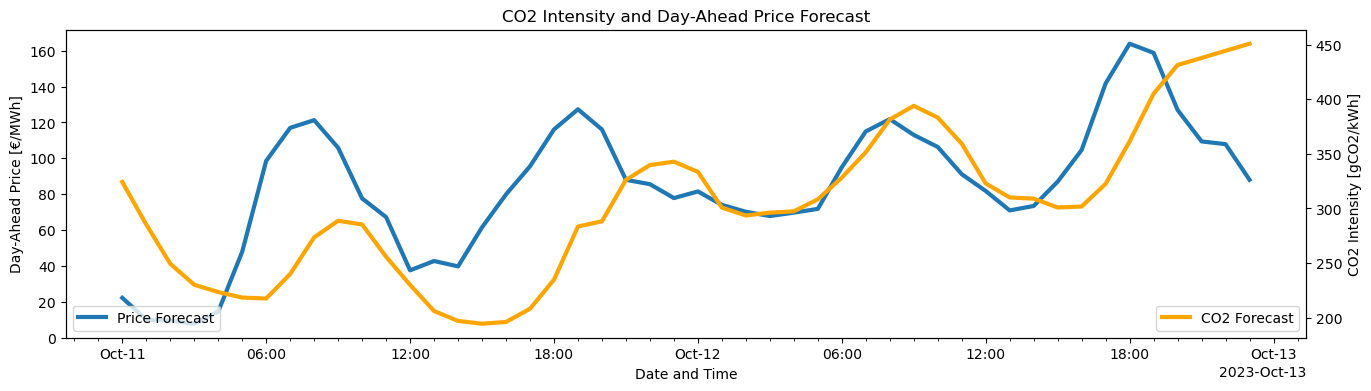

In [7]:
plot_forecasts(price_forecast, CO2_forecast, features)